#Imports & basic config

In [1]:
!pip install -q "transformers>=4.48.0" peft kagglehub fire

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 3.5 MB/s eta 0:00:00


In [2]:
import transformers
print(transformers.__version__)


4.57.2


In [3]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
FOLDERNAME = 'UW_Courses/eep596 dl/final_project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/UW_Courses/eep596 dl/final_project


In [4]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from collections import Counter
from typing import List, Any
import kagglehub

# Import necessary models and tools
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel

# [FIX] Use modern amp imports
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.utils.checkpoint import checkpoint
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer, util

# ==========================================
# 1. Configuration and Setup
# ==========================================
class Config:
    seed = 42
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Training parameters
    batch_size = 32        # Increase to 64 if VRAM allows
    num_epochs = 100        # Set to 20 for demo, 50-100 for actual training
    learning_rate = 5e-5   # Use a small LR for Fine-tuning (BERT is sensitive)
    weight_decay = 1e-4
    max_len = 128          # 128 is usually sufficient for medical VQA and saves resources compared to 512

    # Data path
    data_dir = Path("./vqa_data")

    # Checkpoint path
    checkpoint_dir = Path("ResNet50")
    checkpoint_path = checkpoint_dir / "best_model.pth"

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(Config.seed)
print(f"Device: {Config.device}")

# Ensure checkpoint directory exists
Config.checkpoint_dir.mkdir(parents=True, exist_ok=True)

Device: cuda


#VQADataset + training wrapper dataset

In [5]:
# ==========================================
# 2. Data Download and Preprocessing
# ==========================================
def prepare_data():
    # 1. Download
    print("Downloading dataset...")
    kaggle_root = Path(kagglehub.dataset_download("mitanshuchakrawarty/medical-visual-question-answering"))

    # Find CSV/JSON files
    candidates = list(kaggle_root.rglob("*.csv")) + list(kaggle_root.rglob("*.json"))
    if not candidates:
        raise FileNotFoundError("No csv/json found.")
    data_path = candidates[0]

    # Read and unify columns
    if data_path.suffix == ".json":
        df = pd.read_json(data_path)
    else:
        df = pd.read_csv(data_path)

    # Simple column mapping (adjust based on actual dataset columns)
    # Assuming columns are 'image_name', 'question', 'answer'
    df = df.rename(columns={"image_name": "image_id", "question": "question", "answer": "answer"})
    df["image_id"] = df["image_id"].apply(lambda x: Path(str(x)).stem) # Remove file extension

    # Split
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=Config.seed)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=Config.seed)

    # Prepare image path Map
    image_map = {}
    for ext in ["png", "jpg", "jpeg"]:
        for p in kaggle_root.rglob(f"*.{ext}"):
            image_map[p.stem] = p

    return train_df, val_df, test_df, image_map

train_df, val_df, test_df, image_map = prepare_data()
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Build Label Vocabulary
def build_vocab(df_list):
    all_answers = []
    for df in df_list:
        all_answers.extend(df["answer"].astype(str).tolist())

    # Build a complete Label Space here to avoid train/test inconsistency
    counter = Counter(all_answers)
    vocab = sorted(counter.keys())

    answer2idx = {ans: i for i, ans in enumerate(vocab)}
    idx2answer = {i: ans for i, ans in enumerate(vocab)}
    return answer2idx, idx2answer

# Build Vocab using all data (simulating the fixed answer_space.txt)
answer2idx, idx2answer = build_vocab([train_df, val_df, test_df])
NUM_ANSWERS = len(answer2idx)
print(f"Total Labels: {NUM_ANSWERS}")

100%|██████████| 16.1M/16.1M [00:00<00:00, 117MB/s] 

Extracting files...


Train: 1798, Val: 225, Test: 225
Total Labels: 557


#Dataset Definition

In [6]:
# ==========================================
# 3. Dataset Definition
# ==========================================
class MedicalVQADataset(Dataset):
    def __init__(self, df, image_map, answer2idx, transform=None, tokenizer=None, max_len=128):
        self.df = df
        self.image_map = image_map
        self.answer2idx = answer2idx
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row["image_id"]
        question = str(row["question"])
        answer = str(row["answer"])

        # 1. Process Image
        img_path = self.image_map.get(img_id)
        if img_path is None:
            # Fallback: create a black image if missing (robustness)
            image = Image.new('RGB', (224, 224))
        else:
            image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # 2. Process Text (using BertTokenizer)
        encoding = self.tokenizer(
            question,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_len
        )
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)

        # 3. Process Label
        label = self.answer2idx.get(answer, 0) # Default to 0 if not found

        return image, input_ids, attention_mask, torch.tensor(label, dtype=torch.long)

# Transforms & Tokenizer
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# DataLoaders
train_ds = MedicalVQADataset(train_df, image_map, answer2idx, img_transform, tokenizer, Config.max_len)
val_ds = MedicalVQADataset(val_df, image_map, answer2idx, img_transform, tokenizer, Config.max_len)
test_ds = MedicalVQADataset(test_df, image_map, answer2idx, img_transform, tokenizer, Config.max_len)

train_loader = DataLoader(train_ds, batch_size=Config.batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=Config.batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=Config.batch_size, shuffle=False, num_workers=2, pin_memory=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

#Model Training

In [8]:
# ==========================================
# 4. Improved Model
# ==========================================
class ImprovedVQAModel(nn.Module):
    def __init__(self, num_answers):
        super().__init__()
        # 1. Image Encoder (ResNet50)
        self.cnn = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.cnn.fc = nn.Identity() # Remove classifier -> output 2048 dim

        # 2. Text Encoder (BERT)
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # 3. Fusion & Classifier
        self.fc1 = nn.Linear(2048 + 768, 1024)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_answers)

    def forward(self, images, input_ids, attention_mask):
        # [Key Improvement] Use checkpoint to save VRAM

        # Process ResNet
        # Note: Checkpoint input usually needs requires_grad, but images are leaf nodes.
        # Direct call is safer under mixed precision unless VRAM is extremely tight.
        # We perform standard forward on ResNet and checkpoint on BERT (as BERT is heavier).
        img_feat = self.cnn(images) # [B, 2048]

        # Process BERT (using Checkpoint)
        # Lambda is used to match checkpoint parameter requirements
        if self.training:
            bert_output = checkpoint(
                lambda i, m: self.bert(input_ids=i, attention_mask=m),
                input_ids,
                attention_mask,
                use_reentrant=False
            )
        else:
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        txt_feat = bert_output.last_hidden_state[:, 0, :] # [B, 768] (CLS token)

        # Fusion
        combined = torch.cat((img_feat, txt_feat), dim=1) # [B, 2816]

        x = self.fc1(combined)
        x = torch.relu(x)
        x = self.dropout(x)
        logits = self.fc2(x)

        return logits

model = ImprovedVQAModel(NUM_ANSWERS).to(Config.device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 65.3MB/s]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# ==========================================
# 5. Training and Validation Loop
# ==========================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.num_epochs)

# [FIX] GradScaler does not take "cuda" as an argument
scaler = GradScaler()

def train_one_epoch(epoch_idx):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch_idx+1}/{Config.num_epochs} [Train]")
    for imgs, ids, mask, labels in pbar:
        imgs, ids, mask, labels = imgs.to(Config.device), ids.to(Config.device), mask.to(Config.device), labels.to(Config.device)

        optimizer.zero_grad()

        # [FIX] Use autocast("cuda") with the new import
        with autocast("cuda"):
            outputs = model(imgs, ids, mask)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        # Calculate simple accuracy
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({'loss': loss.item(), 'acc': correct/total})

    return running_loss / len(train_loader), correct / total

def validate(loader, desc="Val"):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc=desc)
        for imgs, ids, mask, labels in pbar:
            imgs, ids, mask, labels = imgs.to(Config.device), ids.to(Config.device), mask.to(Config.device), labels.to(Config.device)

            with autocast("cuda"):
                outputs = model(imgs, ids, mask)
                loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / len(loader), correct / total

/tmp/ipython-input-3411417464.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
# --- Main Training Loop ---
best_val_acc = 0
history = []

print(f"Checkpoints will be saved to: {Config.checkpoint_path}")

if not hasattr(Config, 'patience'):
    Config.patience = 10
resume_path = Config.checkpoint_dir / "latest_checkpoint.pth"
best_model_path = Config.checkpoint_dir / "best_model.pth"

# ==========================================
# Main Training Loop
# ==========================================
print(f"Checkpoints will be saved to: {Config.checkpoint_dir}")

for epoch in range(Config.num_epochs):
    # 1. Train & Validate
    train_loss, train_acc = train_one_epoch(epoch)
    val_loss, val_acc = validate(val_loader)

    # 2. Step Scheduler
    scheduler.step()

    print(f"Epoch {epoch+1}/{Config.num_epochs}: Train Loss={train_loss:.4f} Acc={train_acc:.4f} | Val Loss={val_loss:.4f} Acc={val_acc:.4f}")

    # 3. Update History
    history.append({
        "epoch": epoch+1,
        "train_loss": train_loss, "train_acc": train_acc,
        "val_loss": val_loss, "val_acc": val_acc
    })

    # [New] Early Stopping Logic
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stopping_counter = 0 # Reset counter on improvement

        # Save "Best" Model
        current_state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'best_val_acc': best_val_acc,
            'history': history,
            'early_stopping_counter': early_stopping_counter
        }
        torch.save(current_state, best_model_path)
        print(f">>> 🌟 New Best Model saved to {best_model_path}!")
    else:
        early_stopping_counter += 1
        print(f"   >>> No improvement. Early stopping counter: {early_stopping_counter}/{Config.patience}")

    # 4. Save "Latest" Checkpoint (Always save for resuming)
    # Construct State Dictionary
    latest_state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'best_val_acc': best_val_acc,
        'history': history,
        'early_stopping_counter': early_stopping_counter # Save counter
    }
    torch.save(latest_state, resume_path)

    # 5. Check Early Stopping
    if early_stopping_counter >= Config.patience:
        print(f"🛑 Early stopping triggered! No improvement for {Config.patience} epochs.")
        break

print("Training Complete!")

Checkpoints will be saved to: ResNet50/best_model.pth
Checkpoints will be saved to: ResNet50


Val: 100%|██████████| 8/8 [00:02<00:00,  3.60it/s]


Epoch 1/100: Train Loss=0.0178 Acc=0.9994 | Val Loss=4.7663 Acc=0.5378
>>> 🌟 New Best Model saved to ResNet50/best_model.pth!


Val: 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Epoch 2/100: Train Loss=0.0201 Acc=0.9994 | Val Loss=4.7288 Acc=0.5378
   >>> No improvement. Early stopping counter: 1/10


Val: 100%|██████████| 8/8 [00:02<00:00,  3.51it/s]


Epoch 3/100: Train Loss=0.0217 Acc=0.9994 | Val Loss=4.7549 Acc=0.5333
   >>> No improvement. Early stopping counter: 2/10


Val: 100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


Epoch 4/100: Train Loss=0.0191 Acc=0.9994 | Val Loss=4.7484 Acc=0.5378
   >>> No improvement. Early stopping counter: 3/10


Val: 100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Epoch 5/100: Train Loss=0.0186 Acc=0.9989 | Val Loss=4.7377 Acc=0.5289
   >>> No improvement. Early stopping counter: 4/10


Val: 100%|██████████| 8/8 [00:03<00:00,  2.55it/s]


Epoch 6/100: Train Loss=0.0190 Acc=0.9994 | Val Loss=4.7298 Acc=0.5333
   >>> No improvement. Early stopping counter: 5/10


Val: 100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Epoch 7/100: Train Loss=0.0170 Acc=1.0000 | Val Loss=4.7616 Acc=0.5333
   >>> No improvement. Early stopping counter: 6/10


Val: 100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch 8/100: Train Loss=0.0173 Acc=1.0000 | Val Loss=4.7542 Acc=0.5289
   >>> No improvement. Early stopping counter: 7/10


Val: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 9/100: Train Loss=0.0178 Acc=1.0000 | Val Loss=4.8118 Acc=0.5289
   >>> No improvement. Early stopping counter: 8/10


Val: 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Epoch 10/100: Train Loss=0.0180 Acc=1.0000 | Val Loss=4.7335 Acc=0.5244
   >>> No improvement. Early stopping counter: 9/10


Val: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 11/100: Train Loss=0.0226 Acc=0.9989 | Val Loss=4.7735 Acc=0.5200
   >>> No improvement. Early stopping counter: 10/10
🛑 Early stopping triggered! No improvement for 10 epochs.
Training Complete!


In [ ]:
#if not hasattr(Config, 'patience'):
Config.patience = 20
from torch.utils.checkpoint import checkpoint
# ==========================================
# Setup Optimizer & Scheduler & Scaler
# ==========================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.num_epochs)
# [FIX] Use modern GradScaler syntax to avoid warnings
scaler = torch.amp.GradScaler("cuda")

# ==========================================
# RESUME LOGIC (Crucial Part)
# ==========================================
start_epoch = 0
best_val_acc = 0.0
early_stopping_counter = 0 # [New] Initialize counter
history = []

# Define path for the "latest" state (for resuming) vs "best" model (for evaluation)
# Using the same path is risky if the latest epoch is worse than the best one.
resume_path = Config.checkpoint_dir / "latest_checkpoint.pth"
best_model_path = Config.checkpoint_dir / "best_model.pth"

if resume_path.exists():
    print(f"🔄 Found checkpoint at {resume_path}. Resuming training...")

    # [FIX] Rename variable to 'ckpt' to avoid shadowing the 'checkpoint' function
    ckpt = torch.load(resume_path, map_location=Config.device)

    # 1. Load Model Weights
    model.load_state_dict(ckpt['model_state_dict'])

    # 2. Load Optimizer State (Momentum, etc.)
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])

    # 3. Load Scheduler State (Current Learning Rate)
    scheduler.load_state_dict(ckpt['scheduler_state_dict'])

    # 4. Load Scaler State (Mixed Precision)
    if 'scaler_state_dict' in ckpt:
        scaler.load_state_dict(ckpt['scaler_state_dict'])

    # 5. Restore training progress variables
    start_epoch = ckpt['epoch'] + 1  # Start from the NEXT epoch
    best_val_acc = ckpt['best_val_acc']
    history = ckpt.get('history', [])

    # [New] Restore early stopping counter
    early_stopping_counter = ckpt.get('early_stopping_counter', 0)

    print(f"   >>> Resuming from Epoch {start_epoch+1}")
    print(f"   >>> Best Val Acc so far: {best_val_acc:.4f}")
    print(f"   >>> Early Stopping Counter: {early_stopping_counter}/{Config.patience}")

else:
    print("🚀 No checkpoint found. Starting training from scratch.")

# ==========================================
# Main Training Loop
# ==========================================
print(f"Checkpoints will be saved to: {Config.checkpoint_dir}")

for epoch in range(start_epoch, Config.num_epochs):
    # 1. Train & Validate
    train_loss, train_acc = train_one_epoch(epoch)
    val_loss, val_acc = validate(val_loader)

    # 2. Step Scheduler
    scheduler.step()

    print(f"Epoch {epoch+1}/{Config.num_epochs}: Train Loss={train_loss:.4f} Acc={train_acc:.4f} | Val Loss={val_loss:.4f} Acc={val_acc:.4f}")

    # 3. Update History
    history.append({
        "epoch": epoch+1,
        "train_loss": train_loss, "train_acc": train_acc,
        "val_loss": val_loss, "val_acc": val_acc
    })

    # [New] Early Stopping Logic
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stopping_counter = 0 # Reset counter on improvement

        # Save "Best" Model
        current_state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'best_val_acc': best_val_acc,
            'history': history,
            'early_stopping_counter': early_stopping_counter
        }
        torch.save(current_state, best_model_path)
        print(f">>> 🌟 New Best Model saved to {best_model_path}!")
    else:
        early_stopping_counter += 1
        print(f"   >>> No improvement. Early stopping counter: {early_stopping_counter}/{Config.patience}")

    # 4. Save "Latest" Checkpoint (Always save for resuming)
    # Construct State Dictionary
    latest_state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'best_val_acc': best_val_acc,
        'history': history,
        'early_stopping_counter': early_stopping_counter # Save counter
    }
    torch.save(latest_state, resume_path)

    # 5. Check Early Stopping
    if early_stopping_counter >= Config.patience:
        print(f"🛑 Early stopping triggered! No improvement for {Config.patience} epochs.")
        break

print("Training Complete!")

🔄 Found checkpoint at ResNet50/latest_checkpoint.pth. Resuming training...
   >>> Resuming from Epoch 14
   >>> Best Val Acc so far: 0.5378
   >>> Early Stopping Counter: 12/20
Checkpoints will be saved to: ResNet50


Val: 100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch 14/100: Train Loss=0.0165 Acc=1.0000 | Val Loss=4.8282 Acc=0.5200
   >>> No improvement. Early stopping counter: 13/20


Val: 100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch 15/100: Train Loss=0.0176 Acc=1.0000 | Val Loss=4.8334 Acc=0.5200
   >>> No improvement. Early stopping counter: 14/20


Val: 100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch 16/100: Train Loss=0.0168 Acc=0.9994 | Val Loss=4.7884 Acc=0.5244
   >>> No improvement. Early stopping counter: 15/20


Val: 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]


Epoch 17/100: Train Loss=0.0167 Acc=0.9994 | Val Loss=4.7978 Acc=0.5200
   >>> No improvement. Early stopping counter: 16/20


Val: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 18/100: Train Loss=0.0159 Acc=0.9994 | Val Loss=4.8392 Acc=0.5156
   >>> No improvement. Early stopping counter: 17/20


Val: 100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Epoch 19/100: Train Loss=0.0159 Acc=1.0000 | Val Loss=4.8621 Acc=0.5200
   >>> No improvement. Early stopping counter: 18/20


Val: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Epoch 20/100: Train Loss=0.0161 Acc=1.0000 | Val Loss=4.8329 Acc=0.5200
   >>> No improvement. Early stopping counter: 19/20


Val: 100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


Epoch 21/100: Train Loss=0.0140 Acc=1.0000 | Val Loss=4.8584 Acc=0.5289
   >>> No improvement. Early stopping counter: 20/20
🛑 Early stopping triggered! No improvement for 20 epochs.
Training Complete!


#Evaluation

In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
# ==========================================
# 6. Evaluation & Create df_results (Fixes NameError)
# ==========================================
print("\nRunning Final Evaluation to generate results...")
best_model_path = Config.checkpoint_dir / "best_model.pth"
# Load SBERT model
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Load the best model weights
if best_model_path.exists():
    print(f"Loading best model from {best_model_path}...")
    checkpoint = torch.load(best_model_path, map_location=Config.device)
    # Handle state dict wrapper
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
else:
    print("⚠️ Warning: No best model found, utilizing current model weights.")

model.eval()

predictions = []
ground_truths = []
similarities = []

with torch.no_grad():
    for imgs, ids, mask, labels in tqdm(test_loader, desc="Testing"):
        imgs = imgs.to(Config.device)
        ids = ids.to(Config.device)
        mask = mask.to(Config.device)
        labels = labels.to(Config.device)

        with torch.cuda.amp.autocast():
            outputs = model(imgs, ids, mask)

        _, preds = torch.max(outputs, 1)

        for p, g in zip(preds, labels):
            # Ensure idx2answer is available (from previous setup code)
            pred_text = idx2answer[p.item()]
            gt_text = idx2answer[g.item()]

            predictions.append(pred_text)
            ground_truths.append(gt_text)

            # SBERT Similarity
            p_clean = pred_text.replace("_", " ").lower()
            g_clean = gt_text.replace("_", " ").lower()

            emb1 = sbert_model.encode(p_clean, convert_to_tensor=True)
            emb2 = sbert_model.encode(g_clean, convert_to_tensor=True)
            sim = util.cos_sim(emb1, emb2).item()
            similarities.append(sim)

# Create the DataFrame needed for visualization
df_results = pd.DataFrame({
    "gt_answer": ground_truths,
    "pred_answer": predictions,
    "is_correct": [1 if p == g else 0 for p, g in zip(predictions, ground_truths)],
    "similarity": similarities
})



Running Final Evaluation to generate results...
Loading best model from ResNet50/best_model.pth...


Testing:   0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipython-input-2977207781.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Testing: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


In [12]:

# ==========================================
# 9. Final Evaluation & Metric Generation
# ==========================================
print("\nRunning Final Evaluation...")

# Load SBERT model
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Load best weights
if best_model_path.exists():
    print(f"Loading best model from {best_model_path}...")
    best_ckpt = torch.load(best_model_path, map_location=Config.device)
    if 'model_state_dict' in best_ckpt:
        model.load_state_dict(best_ckpt['model_state_dict'])
    else:
        model.load_state_dict(best_ckpt)
else:
    print("⚠️ Warning: No best model found, utilizing current model weights.")

model.eval()

predictions = []
ground_truths = []
similarities = []

with torch.no_grad():
    for imgs, ids, mask, labels in tqdm(test_loader, desc="Testing"):
        imgs = imgs.to(Config.device)
        ids = ids.to(Config.device)
        mask = mask.to(Config.device)
        labels = labels.to(Config.device)

        with torch.amp.autocast("cuda"):
            outputs = model(imgs, ids, mask)

        _, preds = torch.max(outputs, 1)

        for p, g in zip(preds, labels):
            pred_text = idx2answer[p.item()]
            gt_text = idx2answer[g.item()]

            predictions.append(pred_text)
            ground_truths.append(gt_text)

            p_clean = pred_text.replace("_", " ").lower().strip()
            g_clean = gt_text.replace("_", " ").lower().strip()

            emb1 = sbert_model.encode(p_clean, convert_to_tensor=True)
            emb2 = sbert_model.encode(g_clean, convert_to_tensor=True)
            sim = util.cos_sim(emb1, emb2).item()
            similarities.append(sim)

# Create DataFrame for Visualization
# [MODIFIED] is_correct now ignores case (lower())
df_results = pd.DataFrame({
    "gt_answer": ground_truths,
    "pred_answer": predictions,
    "is_correct": [1 if p.lower().strip() == g.lower().strip() else 0 for p, g in zip(predictions, ground_truths)],
    "similarity": similarities
})



Running Final Evaluation...
Loading best model from ResNet50/best_model.pth...


Testing: 100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


In [13]:
# [NEW] Calculate and Print Final Metrics
final_acc = df_results["is_correct"].mean()
avg_sim = df_results["similarity"].mean()

print("="*30)
print(f"Final Test Accuracy: {final_acc:.4f}")
print(f"Final SBERT Similarity: {avg_sim:.4f}")
print("="*30)

Final Test Accuracy: 0.6089
Final SBERT Similarity: 0.7222


Total distinct answers: 89
                                                  freq       acc
gt_answer                                                       
No                                                  67  0.776119
Yes                                                 50  0.700000
Axial                                                6  0.833333
Fat                                                  3  0.333333
Pa                                                   3  0.666667
Left                                                 3  0.000000
Right                                                3  1.000000
Air                                                  2  0.000000
Left hepatic lobe                                    2  0.000000
Enlarged                                             2  0.500000
Pleural effusion                                     2  0.500000
Right frontal lobe                                   2  0.500000
Hyperintense                                         2  0.00000

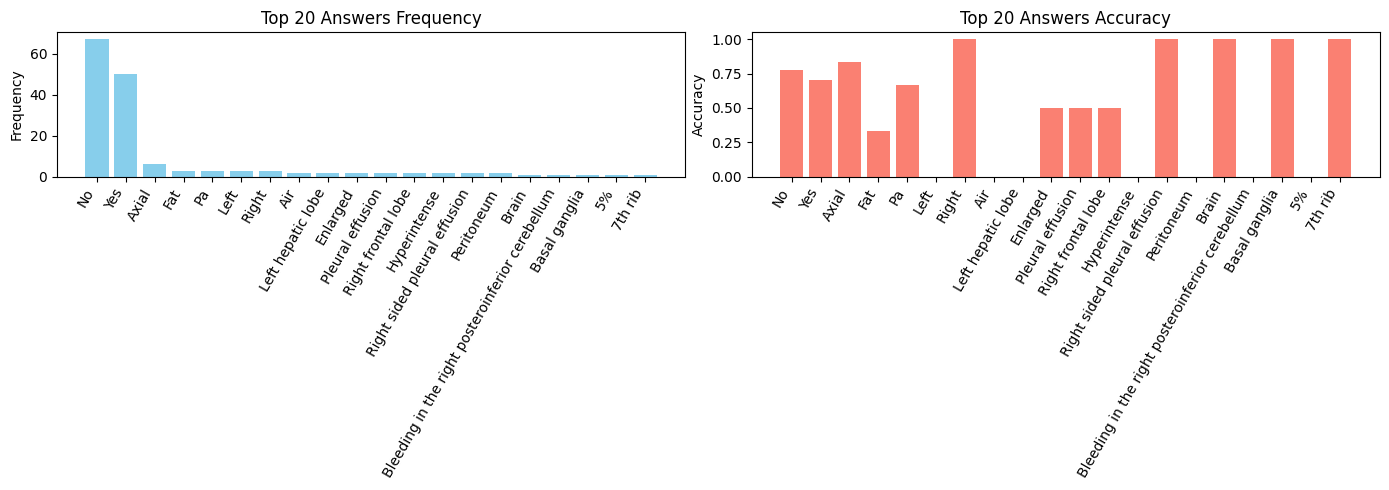

In [14]:
# 10.1 Statistics
# [MODIFIED] Normalize gt_answer directly to merge "no"/"No" (Capitalize for display)
df_results['gt_answer'] = df_results['gt_answer'].apply(lambda x: x.lower().strip().capitalize())

# 統計分析 (回復為您原本的寫法)
stats = (
    df_results
    .groupby("gt_answer")["is_correct"]
    .agg(["count", "mean"])        # count: 出現次數, mean: 正確率
    .rename(columns={"count": "freq", "mean": "acc"})
    .sort_values("freq", ascending=False)
)

print(f"Total distinct answers: {len(stats)}")
TOP_N = 20
top_stats = stats.head(TOP_N)
print(top_stats)

# 畫圖
plt.figure(figsize=(14, 5))

# 1. 頻率圖
plt.subplot(1, 2, 1)
plt.bar(range(len(top_stats)), top_stats["freq"], color='skyblue')
plt.xticks(range(len(top_stats)), top_stats.index, rotation=60, ha="right")
plt.ylabel("Frequency")
plt.title(f"Top {TOP_N} Answers Frequency")

# 2. 正確率圖
plt.subplot(1, 2, 2)
plt.bar(range(len(top_stats)), top_stats["acc"], color='salmon')
plt.xticks(range(len(top_stats)), top_stats.index, rotation=60, ha="right")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.title(f"Top {TOP_N} Answers Accuracy")

plt.tight_layout()
plt.show()


Plotting Training History...


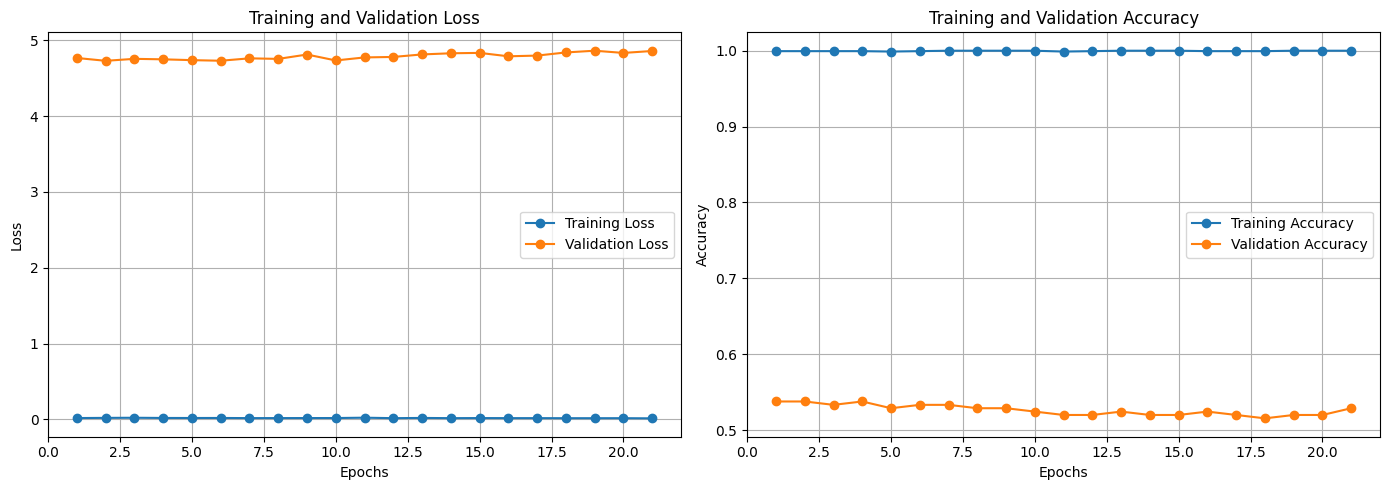

In [ ]:

# ==========================================
# 8. Training History Visualization
# ==========================================
print("\nPlotting Training History...")

# 10.2 Training History
print("\nPlotting Training History...")
if history:
    epochs = [x['epoch'] for x in history]
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    train_accs = [x['train_acc'] for x in history]
    val_accs = [x['val_acc'] for x in history]

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss History')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_accs, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy History')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Generating Qualitative Examples...


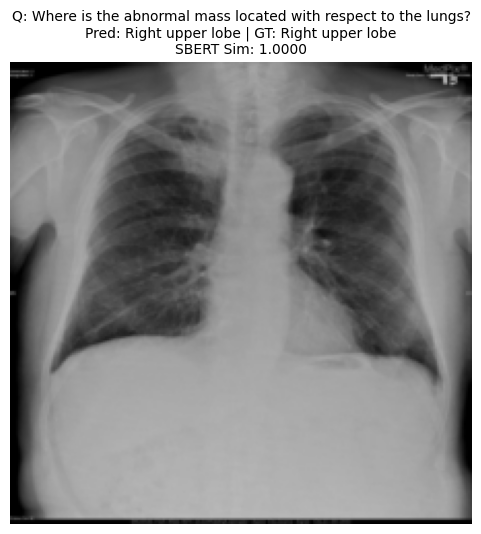

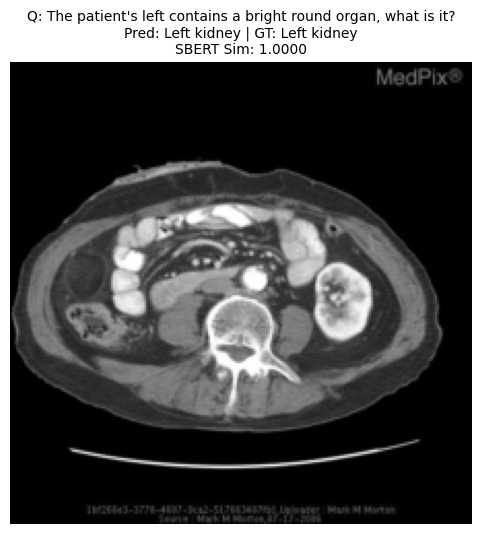

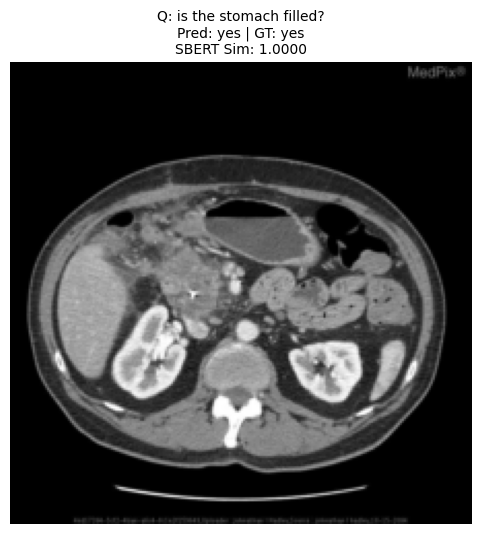

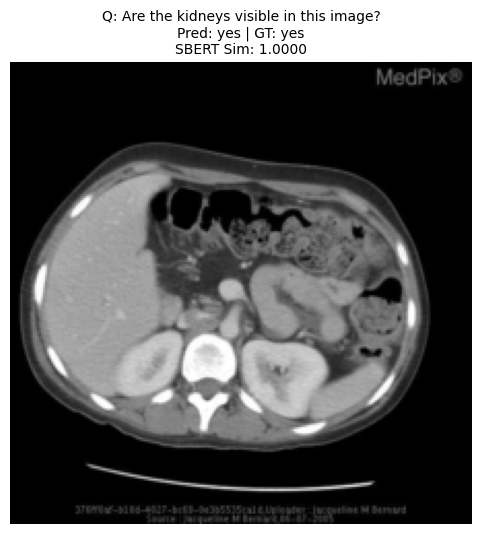

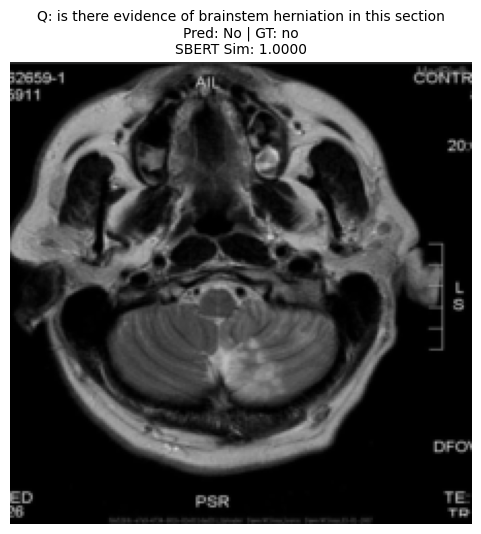

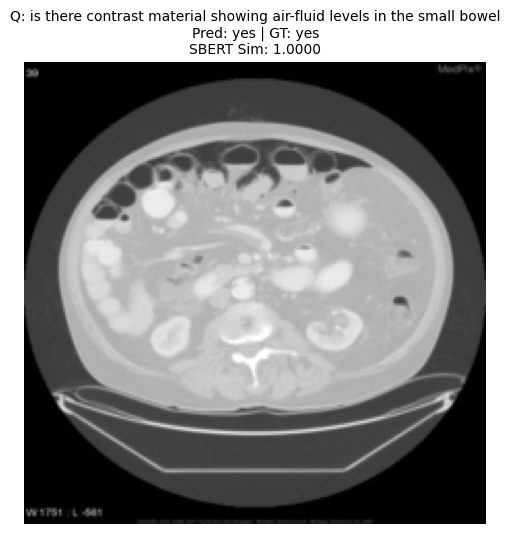

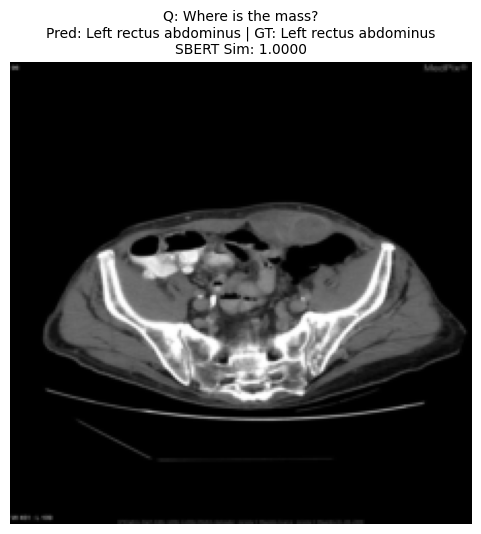

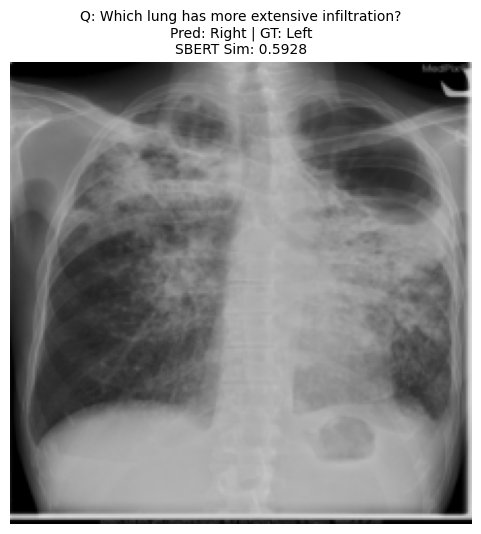

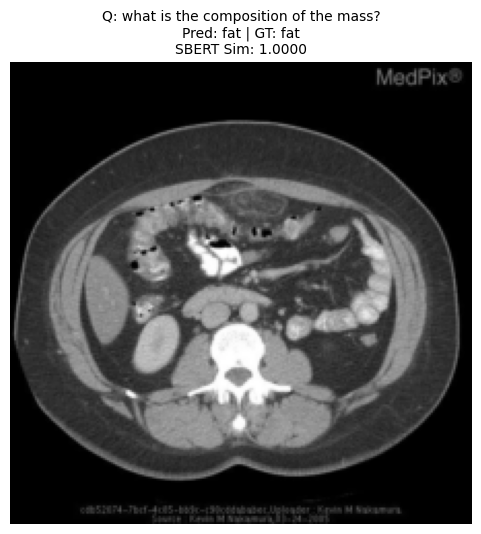

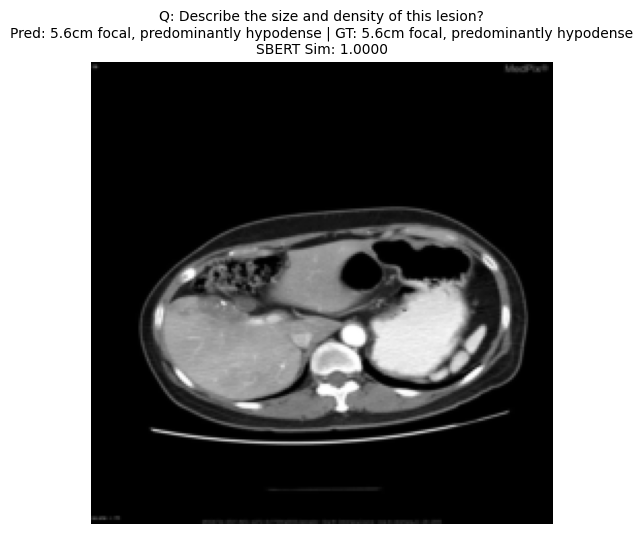

In [ ]:
# ==========================================
# 9. Qualitative Results (Images & Predictions)
# ==========================================
print("\nGenerating Qualitative Examples...")
def preprocess_answer(answer):
    return answer.replace('_', ' ')

count = 0
max_examples = 10

with torch.no_grad():
    for batch_idx, (imgs, ids, mask, labels) in enumerate(test_loader):
        imgs = imgs.to(Config.device)
        ids = ids.to(Config.device)
        mask = mask.to(Config.device)
        labels = labels.to(Config.device)

        with torch.amp.autocast("cuda"):
            outputs = model(imgs, ids, mask)

        _, preds = torch.max(outputs, 1)

        for i in range(imgs.size(0)):
            if count >= max_examples:
                break

            pred_idx = preds[i].item()
            label_idx = labels[i].item()

            predicted_answer = preprocess_answer(idx2answer[pred_idx])
            actual_answer = preprocess_answer(idx2answer[label_idx])

            # Fetch Question
            global_idx = batch_idx * test_loader.batch_size + i
            if global_idx < len(test_ds):
                question = test_ds.df.iloc[global_idx]['question']
            else:
                question = "Unknown"

            # Re-calculate sim just for display
            emb1 = sbert_model.encode(predicted_answer, convert_to_tensor=True)
            emb2 = sbert_model.encode(actual_answer, convert_to_tensor=True)
            similarity = util.cos_sim(emb1, emb2).item()

            # Denormalize Image
            img_tensor = imgs[i].cpu()
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img_disp = img_tensor * std + mean
            img_disp = torch.clamp(img_disp, 0, 1)
            img_np = img_disp.permute(1, 2, 0).numpy()

            plt.figure(figsize=(6, 6))
            plt.imshow(img_np)
            plt.title(f"Q: {question}\nPred: {predicted_answer} | GT: {actual_answer}\nSBERT Sim: {similarity:.4f}", fontsize=10)
            plt.axis('off')
            plt.show()

            count += 1

        if count >= max_examples:
            break